In [1]:
import numpy as np
np.random.seed(26)
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
headers_file = open('headers.txt', 'r')
headers = [line.strip('\n') for line in headers_file]
train_data = pd.read_csv('/content/train_imperson_without4n7_balanced_data.csv', skiprows = 1, header=None, names=headers)
test_data = pd.read_csv('/content/test_imperson_without4n7_balanced_data.csv', skiprows = 1, header = None, names=headers)
print(train_data.shape)
print(test_data.shape)
print(train_data.head(20))
print(train_data.describe())
train_data_sub = train_data.loc[:,train_data.apply(pd.Series.nunique) != 1]
test_data_sub = test_data.loc[:,train_data.apply(pd.Series.nunique) != 1]
headers_sub = list(train_data_sub)
print(train_data_sub.shape)
print(test_data_sub.shape)

(97044, 153)
(40158, 153)
    frame.interface_id  frame.dlt  ...  data.len  class
0                    0          0  ...       0.0      0
1                    0          0  ...       0.0      0
2                    0          0  ...       0.0      0
3                    0          0  ...       0.0      0
4                    0          0  ...       0.0      0
5                    0          0  ...       0.0      0
6                    0          0  ...       0.0      0
7                    0          0  ...       0.0      0
8                    0          0  ...       0.0      0
9                    0          0  ...       0.0      0
10                   0          0  ...       0.0      0
11                   0          0  ...       0.0      0
12                   0          0  ...       0.0      0
13                   0          0  ...       0.0      0
14                   0          0  ...       0.0      0
15                   0          0  ...       0.0      0
16                   0

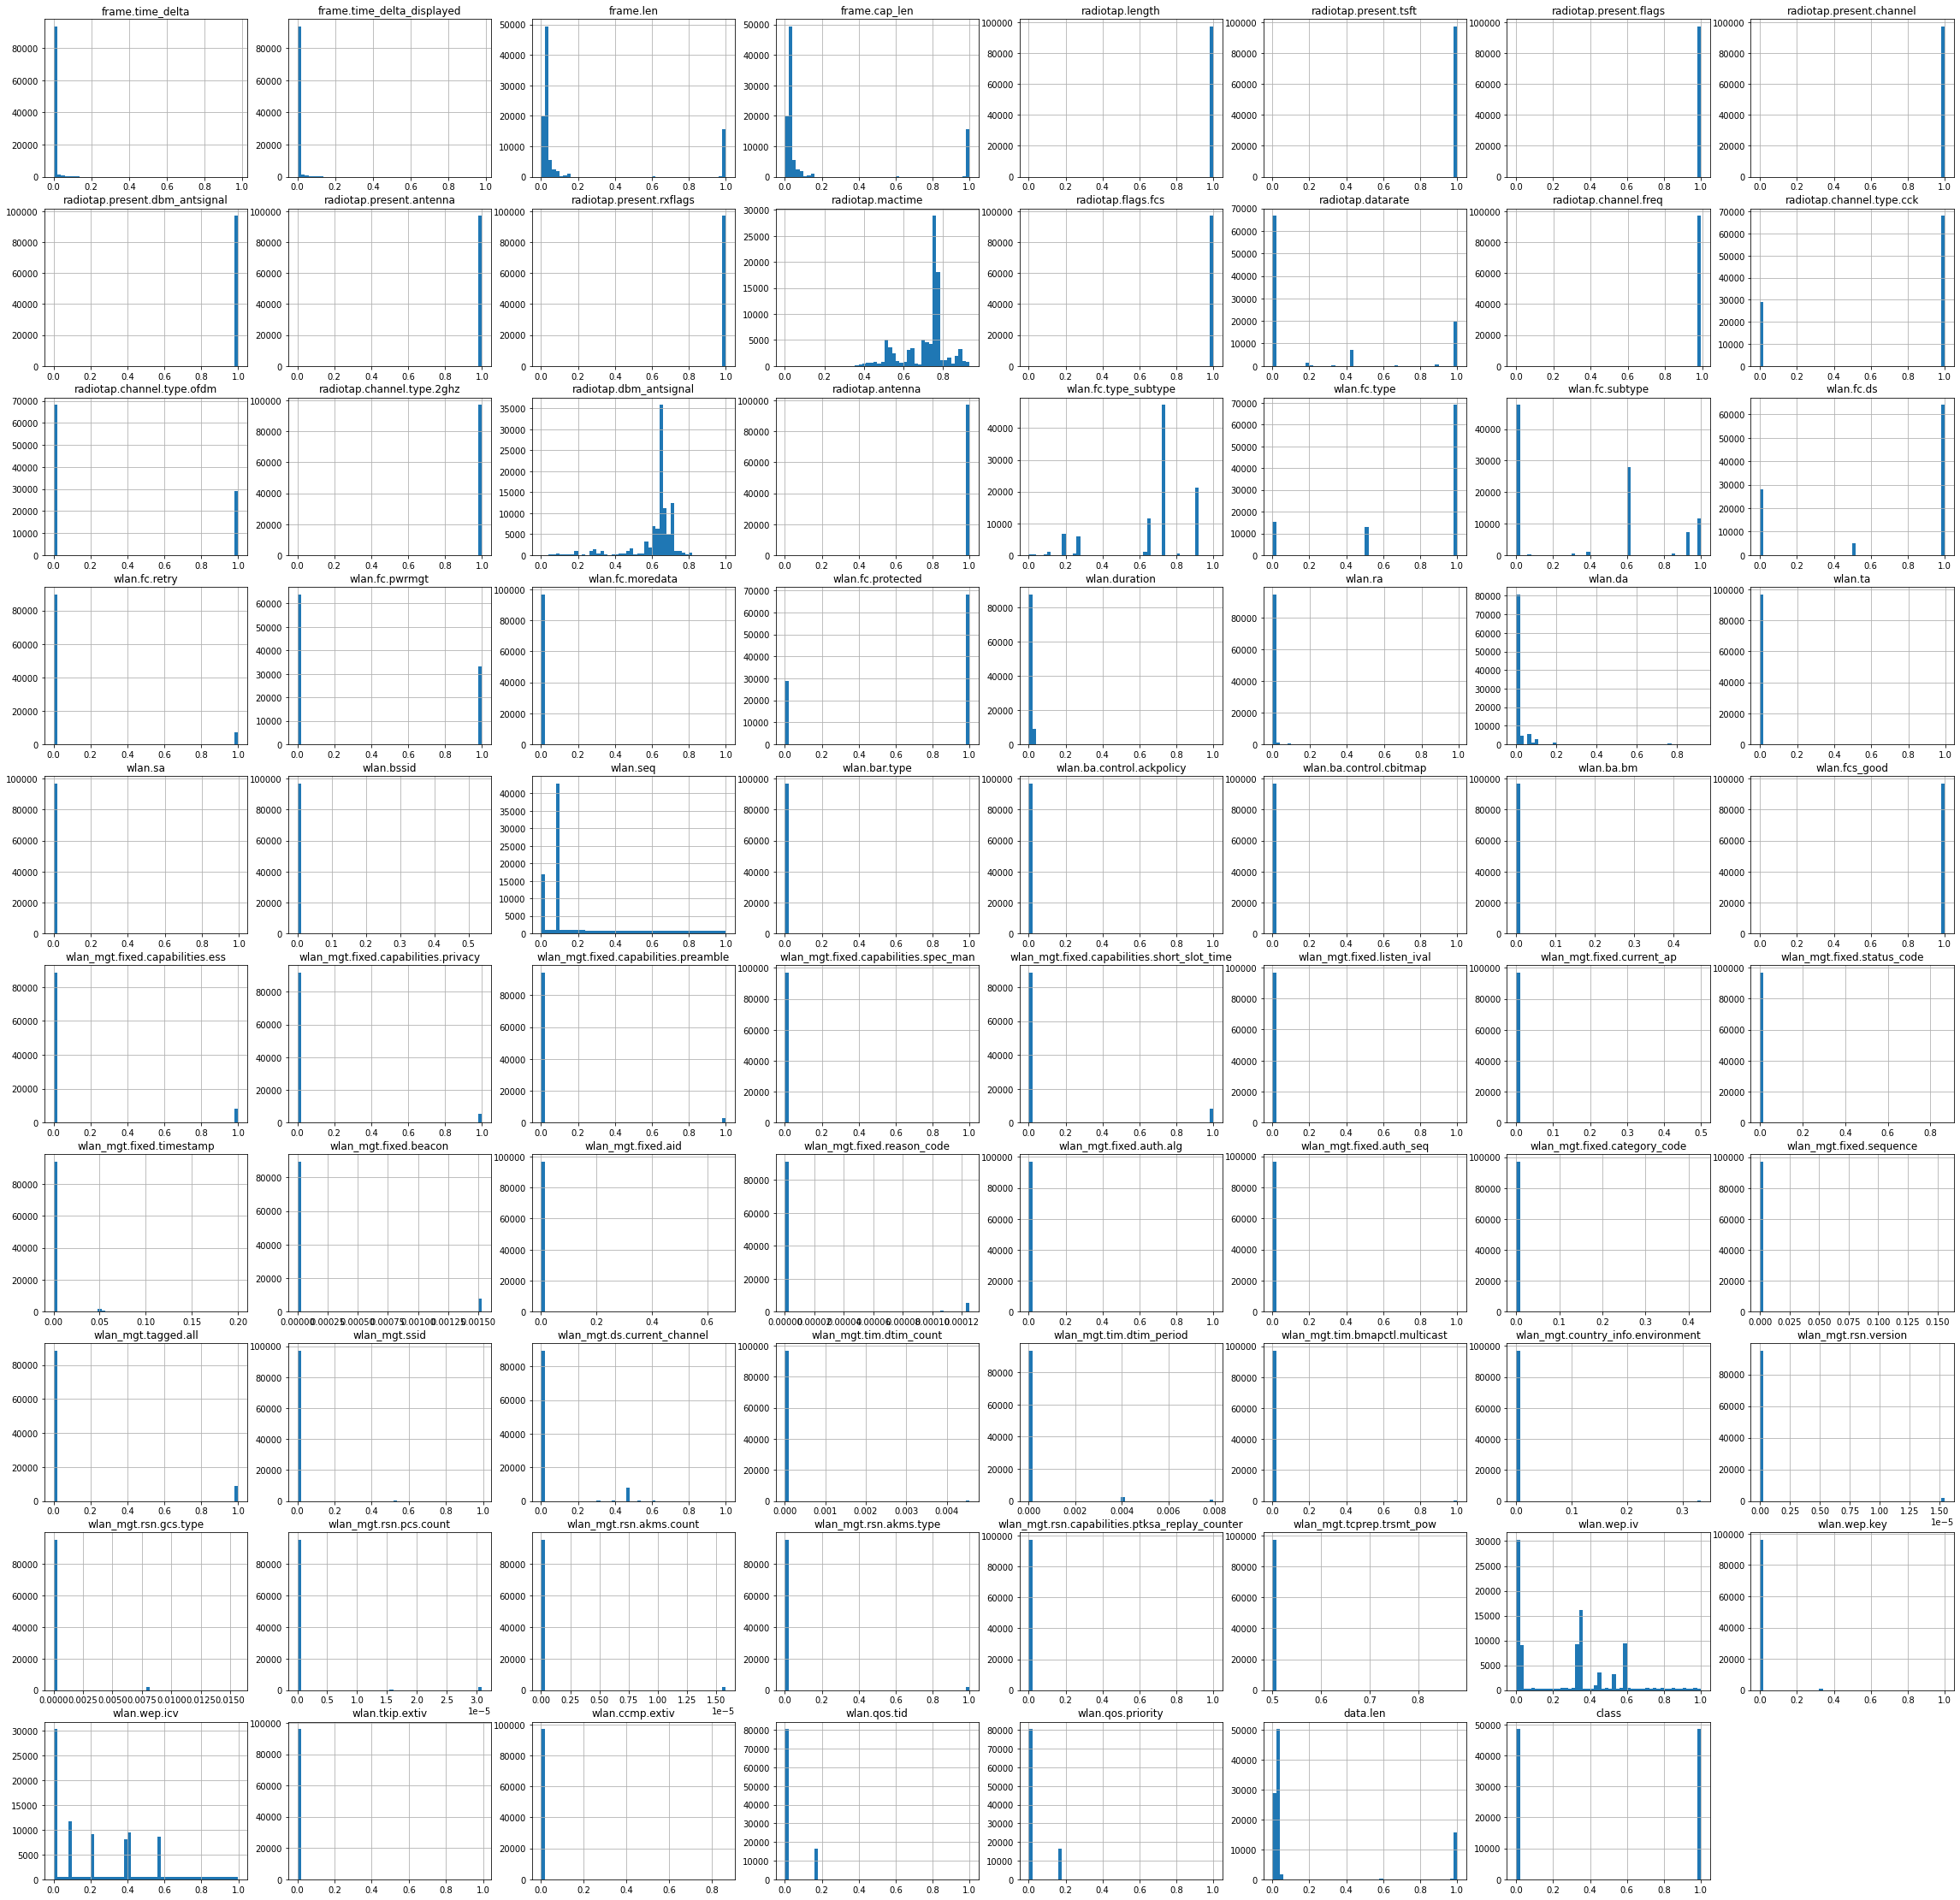

In [3]:
fig = plt.figure(figsize=(40, 40))
for i, feature in enumerate(headers_sub):
  ax=fig.add_subplot(10, 8, i+1)
  train_data_sub[feature].hist(bins=50, label = feature)
  ax.set_title(feature)
plt.show()

In [4]:
for feature in headers_sub:
  if len(np.unique(train_data_sub.loc[:, feature]))==2:
    value_counts = train_data_sub.loc[:, feature].value_counts()
    print(value_counts)

1    97023
0       21
Name: radiotap.length, dtype: int64
1    97023
0       21
Name: radiotap.present.tsft, dtype: int64
1    97023
0       21
Name: radiotap.present.flags, dtype: int64
1    97023
0       21
Name: radiotap.present.channel, dtype: int64
1    97023
0       21
Name: radiotap.present.dbm_antsignal, dtype: int64
1    97023
0       21
Name: radiotap.present.antenna, dtype: int64
1    97023
0       21
Name: radiotap.present.rxflags, dtype: int64
1    97023
0       21
Name: radiotap.flags.fcs, dtype: int64
1    68083
0    28961
Name: radiotap.channel.type.cck, dtype: int64
0    68104
1    28940
Name: radiotap.channel.type.ofdm, dtype: int64
1    97023
0       21
Name: radiotap.channel.type.2ghz, dtype: int64
1    97023
0       21
Name: radiotap.antenna, dtype: int64
0    89732
1     7312
Name: wlan.fc.retry, dtype: int64
0    63986
1    33058
Name: wlan.fc.pwrmgt, dtype: int64
0    96944
1      100
Name: wlan.fc.moredata, dtype: int64
1    68324
0    28720
Name: wlan.fc.prote

In [5]:
train_data_sub = train_data_sub.drop(['radiotap.length',
'radiotap.present.tsft',
'radiotap.present.flags',
'radiotap.present.channel',
'radiotap.present.dbm_antsignal',
'radiotap.present.antenna',
'radiotap.present.rxflags',
'radiotap.flags.fcs',
'radiotap.channel.type.2ghz',
'radiotap.antenna',
'wlan.fc.moredata',
'wlan.bar.type',
'wlan.ba.control.ackpolicy',
'wlan.ba.control.cbitmap',
'wlan.fcs_good',
'wlan_mgt.fixed.capabilities.spec_man',
'wlan_mgt.fixed.current_ap',
'wlan_mgt.fixed.status_code',
'wlan_mgt.fixed.auth.alg',
'wlan_mgt.fixed.category_code',
'wlan_mgt.tim.bmapctl.multicast',
'wlan_mgt.rsn.capabilities.ptksa_replay_counter',
'wlan_mgt.tcprep.trsmt_pow'], axis = 1)

train_data_sub = train_data_sub.T.drop_duplicates().T
test_data_drop = [col for col in list(test_data_sub) if col not in list(train_data_sub)]
test_data_sub = test_data_sub.drop(test_data_drop, axis=1)
headers = list(train_data_sub)


print(test_data_sub.shape)
print(train_data_sub.shape)

(40158, 53)
(97044, 53)


In [6]:
kbins = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')
y_train = LabelEncoder().fit_transform(train_data_sub.values[:, 52])
y_test = LabelEncoder().fit_transform(test_data_sub.values[:, 52])
x_train = kbins.fit_transform(train_data_sub.values[:, 0:52])
x_test = kbins.fit_transform(test_data_sub.values[:, 0:52])
x_train = Normalizer().fit_transform(x_train)
x_test = Normalizer().fit_transform(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 22 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 33 is constant and will be replaced with 0.
  "replaced with 0." % jj)


In [7]:
chi_fit = chi2(x_train, y_train)
print(chi_fit[0])
to_remove = np.where(chi_fit[0] < 10)
x_train = np.delete(x_train, to_remove, axis = 1)
x_test = np.delete(x_test, to_remove, axis = 1)
print(x_train.shape)

[1.79195460e+00 3.68546253e+03 1.15063271e+02 8.04471606e+03
 3.48393579e+00 3.75577659e+03 1.01047412e+04 4.25381774e+00
 4.52139874e+00 1.10704327e+03 1.11259347e+04 3.78909469e+03
 2.74031229e+03 1.14688625e+04 3.24468448e+03 6.22804083e+01
 4.30212772e+01 5.25207158e+02 2.13475834e+01 2.10153544e+01
 3.32665344e+00 2.54423508e+03 1.40351200e+00 6.11445032e+00
 3.42630397e+01 8.29461250e+02 3.00385092e+00 1.15652004e+02
 3.15971011e+02 5.91141226e+00 3.14312439e+01 2.42429721e+03
 6.38192741e+01 1.95875373e+00 2.06529881e+01 9.58940515e+00
 6.61303249e-01 1.33228624e+02 6.63035563e+02 3.67055098e+01
 5.59049131e+02 2.82471768e+02 5.40423925e+02 5.59049131e+02
 5.59049131e+02 5.40182426e+02 1.34464085e+02 3.02114404e+02
 1.95985132e+02 1.35259293e+01 8.04987904e+02 3.98567114e+03]
(97044, 40)


In [8]:
final_headers = np.delete(headers[0:52], to_remove)
print(final_headers)

['frame.len' 'radiotap.mactime' 'radiotap.datarate'
 'radiotap.channel.type.cck' 'radiotap.channel.type.ofdm' 'wlan.fc.type'
 'wlan.fc.subtype' 'wlan.fc.ds' 'wlan.fc.retry' 'wlan.fc.pwrmgt'
 'wlan.fc.protected' 'wlan.duration' 'wlan.ra' 'wlan.da' 'wlan.ta'
 'wlan.sa' 'wlan.seq' 'wlan_mgt.fixed.capabilities.privacy'
 'wlan_mgt.fixed.capabilities.preamble' 'wlan_mgt.fixed.listen_ival'
 'wlan_mgt.fixed.timestamp' 'wlan_mgt.fixed.aid'
 'wlan_mgt.fixed.reason_code' 'wlan_mgt.fixed.auth_seq'
 'wlan_mgt.tagged.all' 'wlan_mgt.tim.dtim_count'
 'wlan_mgt.tim.dtim_period' 'wlan_mgt.country_info.environment'
 'wlan_mgt.rsn.version' 'wlan_mgt.rsn.gcs.type' 'wlan_mgt.rsn.pcs.count'
 'wlan_mgt.rsn.akms.count' 'wlan_mgt.rsn.akms.type' 'wlan.wep.iv'
 'wlan.wep.key' 'wlan.wep.icv' 'wlan.tkip.extiv' 'wlan.ccmp.extiv'
 'wlan.qos.tid' 'data.len']


Epoch 1/100
131/131 [==============================] - 2s 8ms/step - loss: 0.5898 - accuracy: 0.0294 - val_loss: 0.1764 - val_accuracy: 0.0049
Epoch 2/100
131/131 [==============================] - 1s 4ms/step - loss: 0.1717 - accuracy: 0.0042 - val_loss: 0.1668 - val_accuracy: 3.1226e-05
Epoch 3/100
131/131 [==============================] - 1s 4ms/step - loss: 0.1660 - accuracy: 0.0184 - val_loss: 0.1620 - val_accuracy: 0.0049
Epoch 4/100
131/131 [==============================] - 1s 4ms/step - loss: 0.1579 - accuracy: 0.3265 - val_loss: 0.1457 - val_accuracy: 0.5044
Epoch 5/100
131/131 [==============================] - 1s 4ms/step - loss: 0.1406 - accuracy: 0.4724 - val_loss: 0.1323 - val_accuracy: 0.5412
Epoch 6/100
131/131 [==============================] - 1s 4ms/step - loss: 0.1314 - accuracy: 0.5014 - val_loss: 0.1281 - val_accuracy: 0.4363
Epoch 7/100
131/131 [==============================] - 1s 4ms/step - loss: 0.1273 - accuracy: 0.4109 - val_loss: 0.1255 - val_accuracy: 0.

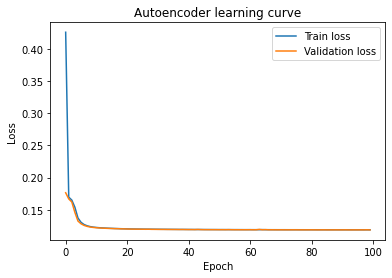

In [9]:
import tensorflow as tf
tf.random.set_seed(26)
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.utils import plot_model
X_train, X_test = train_test_split(x_train, test_size=0.33, shuffle = True)
input_size = 40
hidden_size1 = 30
hidden_size2 = 20
code_size = 10
input_data = Input(shape=(input_size, ))
hidden_1 = Dense(hidden_size1, activation='relu')(input_data)
hidden_2 = Dense(hidden_size2, activation='relu')(hidden_1)
code = Dense(code_size, activation='relu', activity_regularizer = l1(0.001))(hidden_2)
hidden_3 = Dense(hidden_size2, activation='relu')(code)
hidden_4 = Dense(hidden_size1, activation='relu')(hidden_3)
output_data = Dense(input_size, activation='sigmoid')(hidden_4)
autoencoder = Model(input_data, output_data)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics = 'accuracy')
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size = 500, validation_data=(X_test, X_test))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder learning curve')
plt.legend()
plt.show()

In [10]:
encoder = Model(inputs=input_data, outputs=code)
plot_model(encoder, 'sae_fin.png', show_shapes=True)
# save the encoder to file
encoder.save('sae_fin.h5')

In [11]:
x_train_encode = encoder.predict(x_train)
x_test_encode = encoder.predict(x_test)

In [12]:
model = LogisticRegression(solver='liblinear')
enc_fit = model.fit(x_train_encode, y_train)
enc_pred = enc_fit.predict(x_test_encode)
results_enc = classification_report(y_test, enc_pred, digits = 3)
print(results_enc)

              precision    recall  f1-score   support

           0      0.927     0.934     0.931     20079
           1      0.933     0.927     0.930     20079

    accuracy                          0.930     40158
   macro avg      0.930     0.930     0.930     40158
weighted avg      0.930     0.930     0.930     40158



In [13]:
feat_train_enc = np.concatenate((x_train, x_train_encode), axis = 1)
feat_test_enc = np.concatenate((x_test, x_test_encode), axis = 1)
print(feat_train_enc.shape)
print(feat_test_enc.shape)
headers_enc = np.concatenate((final_headers, [x for x in range(1, 11)]), axis=None)

(97044, 50)
(40158, 50)


In [14]:
classifiers = []
classifiers.append(('LR', LogisticRegression(solver='liblinear')))
classifiers.append(('CART', DecisionTreeClassifier()))
classifiers.append(('KNN', KNeighborsClassifier()))
classifiers.append(('NB', GaussianNB()))
cv_results = []
test_results = []
names = []
scoring = 'accuracy'
for name, classifier in classifiers:
  kfold = StratifiedKFold(n_splits=10)
  cv_result = cross_val_score(classifier, feat_train_enc, y_train, cv=kfold, scoring=scoring)
  cv_results.append(cv_result.mean())
  names.append(name)
  train_fit = classifier.fit(feat_train_enc, y_train)
  pred = train_fit.predict(feat_test_enc)
  acc = accuracy_score(y_test, pred)
  test_results.append(acc)
print(cv_results)
print(names)
print(test_results)

[0.9727330327514098, 0.9718673582981552, 0.9813582197921964, 0.9544427554319872]
['LR', 'CART', 'KNN', 'NB']
[0.5445241296877334, 0.5350117037701081, 0.5357587529259425, 0.5031376064545047]


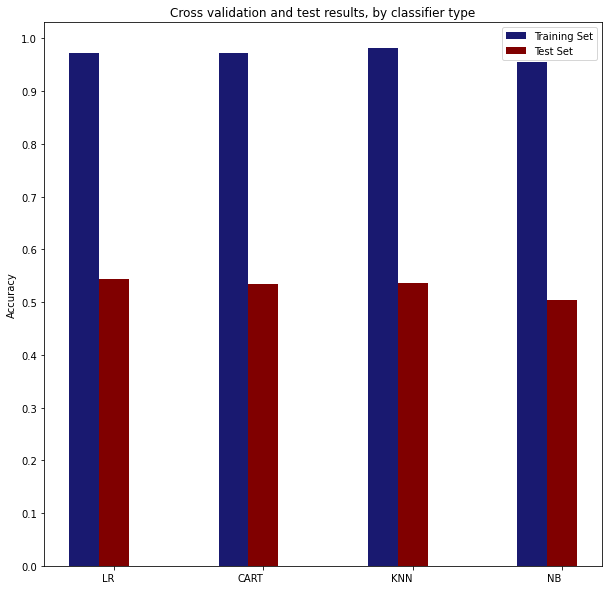

In [15]:
fig3 = plt.figure(figsize=(10,10))
ax_fig3 = fig3.add_subplot(111)
index = np.arange(len(names))
bars_cv = ax_fig3.bar(index, cv_results, width = 0.2, color='midnightblue')
bars_test = ax_fig3.bar(index+0.2, test_results, width= 0.2, color='maroon')
ax_fig3.set_ylabel('Accuracy')
ax_fig3.set_title('Cross validation and test results, by classifier type')
ax_fig3.set_xticks(index+0.2)
ax_fig3.set_yticks(np.arange(0, 1.1, 0.1))
xtickNames = ax_fig3.set_xticklabels(names, ha = 'right')
plt.legend(('Training Set', 'Test Set'))
plt.show()

In [16]:
cv = StratifiedKFold(n_splits=10)
tree = DecisionTreeClassifier()
rfe = RFECV(tree, cv = cv)
fit = rfe.fit(feat_train_enc, y_train)

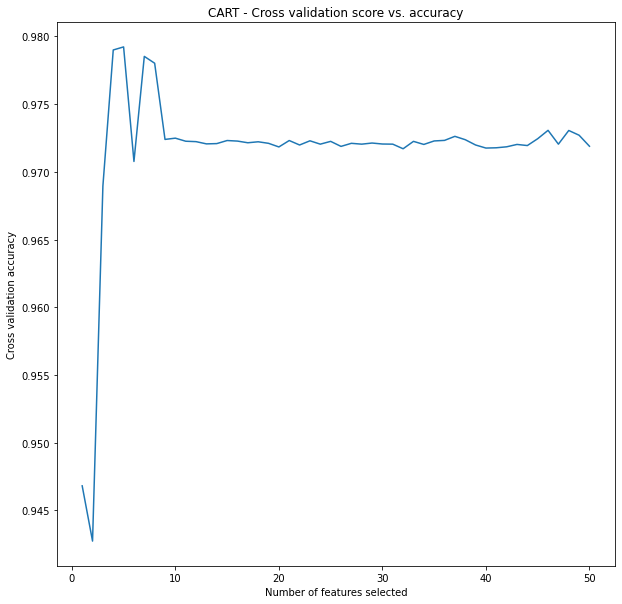

In [17]:
plt.figure(figsize=(10,10))
plt.title('CART - Cross validation score vs. accuracy')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation accuracy")
plt.plot(range(1, len(fit.grid_scores_) + 1), fit.grid_scores_)
plt.show()

In [18]:
forest = RandomForestClassifier(n_estimators = 1000, max_depth = 1, max_features = 'sqrt')
fit_forest = forest.fit(feat_train_enc, y_train)
pred = fit_forest.predict(feat_train_enc)
result = classification_report(y_train, pred, digits = 6)
print(result)

              precision    recall  f1-score   support

           0   0.924513  0.957627  0.940779     48522
           1   0.956053  0.921809  0.938619     48522

    accuracy                       0.939718     97044
   macro avg   0.940283  0.939718  0.939699     97044
weighted avg   0.940283  0.939718  0.939699     97044



In [19]:
pred = fit_forest.predict(feat_test_enc)
result = classification_report(y_test, pred, digits = 6)
print(result)

              precision    recall  f1-score   support

           0   0.855414  0.929329  0.890841     20079
           1   0.922645  0.842920  0.880983     20079

    accuracy                       0.886125     40158
   macro avg   0.889029  0.886125  0.885912     40158
weighted avg   0.889029  0.886125  0.885912     40158



In [20]:
start_fs = time.time()
selection = SelectFromModel(forest, max_features = 7)
selection_fit = selection.fit(feat_train_enc, y_train)
end_fs = time.time()
x_train_kept = selection_fit.transform(feat_train_enc)
x_test_kept = selection_fit.transform(feat_test_enc)

In [21]:
print(selection_fit.get_support())
x_train_kept = selection_fit.transform(feat_train_enc)
x_test_kept = selection_fit.transform(feat_test_enc)
time_fs = end_fs - start_fs
features_kept = np.delete(headers_enc, np.where(selection_fit.get_support()==False))
print(features_kept)
print(time_fs)

[False False False False False  True  True  True False  True  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True  True False
 False False]
['wlan.fc.type' 'wlan.fc.subtype' 'wlan.fc.ds' 'wlan.fc.pwrmgt'
 'wlan.fc.protected' '6' '7']
29.72971224784851


In [22]:
start_lr = time.time()
rfe = RFE(LogisticRegression(solver='liblinear'), n_features_to_select = 7)
rfe_sel = rfe.fit(feat_train_enc, y_train)
end_lr = time.time()
print(rfe_sel.support_)
features_kept_lr = np.delete(headers_enc, np.where(rfe_sel.support_==False))
print(features_kept_lr)
x_train_lr = rfe_sel.transform(feat_train_enc)
x_test_lr = rfe_sel.transform(feat_test_enc)
time_lr = end_lr - start_lr
print(time_lr)

[False False  True False False False  True False False  True False False
 False False False False  True False  True False  True False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False]
['radiotap.datarate' 'wlan.fc.subtype' 'wlan.fc.pwrmgt' 'wlan.seq'
 'wlan_mgt.fixed.capabilities.preamble' 'wlan_mgt.fixed.timestamp' '4']
17.12997007369995


5


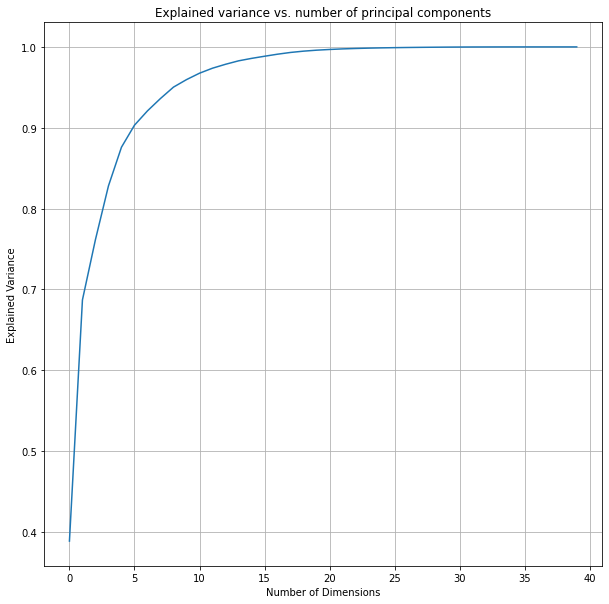

In [49]:
pca = PCA()
x_red = pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=(10, 10))
plt.grid()
plt.plot(cumsum)
plt.title('Explained variance vs. number of principal components')
plt.xlabel('Number of Dimensions')
plt.ylabel('Explained Variance')
d = np.argmax(cumsum>=0.90)
print(d)

In [24]:
pca_3 = PCA(n_components = 5)
red_3 = pca_3.fit(x_train)
x_train_3D = red_3.transform(x_train)
x_test_3D = red_3.transform(x_test)

In [25]:
def produce_metrics(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  mcc = matthews_corrcoef(y_true, y_pred)
  matrix = confusion_matrix(y_true, y_pred)
  print(matrix)
  return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'MCC': mcc}

In [26]:
model = LogisticRegression(solver='liblinear')
enc_fit = model.fit(x_train_encode, y_train)
enc_pred = enc_fit.predict(x_test_encode)
results_enc = produce_metrics(y_test, enc_pred)
fs_fit = model.fit(x_train_kept, y_train)
fs_pred = fs_fit.predict(x_test_kept)
results_fs = produce_metrics(y_test, fs_pred)
lr_fit = model.fit(x_train_lr, y_train)
lr_pred = lr_fit.predict(x_test_lr)
results_lr = produce_metrics(y_test, lr_pred)
pca_fit = model.fit(x_train_3D, y_train)
pca_pred = pca_fit.predict(x_test_3D)
results_pca = produce_metrics(y_test, pca_pred)
datasets = ['Autoencoder Output', 'Feature Selection by RF', 'Feature Selection by LR', 'PCA data']
metrics = ['Accuracy', 'F1', 'Detection Rate', 'MCC']
accuracy = [results_enc['Accuracy'], results_fs['Accuracy'], results_lr['Accuracy'], results_pca['Accuracy']]
precision = [results_enc['F1'], results_fs['F1'], results_lr['F1'], results_pca['F1']]
dr = [results_enc['Recall'], results_fs['Recall'], results_lr['Recall'], results_pca['Recall']]
mcc = [results_enc['MCC'], results_fs['MCC'], results_lr['MCC'], results_pca['MCC']]
data = [accuracy, precision, dr, mcc]
lr_df = pd.DataFrame(data = data, index = metrics, columns = datasets)
lr_df.head()

[[18752  1327]
 [ 1470 18609]]
[[18177  1902]
 [   39 20040]]
[[19225   854]
 [  142 19937]]
[[18662  1417]
 [  197 19882]]


,Autoencoder Output,Feature Selection by RF,Feature Selection by LR,PCA data
Accuracy,0.930350,0.951666,0.975198,0.959809
F1,0.930101,0.953809,0.975630,0.960994
Detection Rate,0.926789,0.998058,0.992928,0.990189
MCC,0.860722,0.907245,0.950994,0.921320


In [27]:
param_grid = {'C':[0.01, 0.1, 1], 'kernel':['linear']}
svc_grid = GridSearchCV(SVC(), param_grid, cv=5)
svc_grid_fit = svc_grid.fit(x_train_kept, y_train) 
mean_score = svc_grid_fit.cv_results_['mean_test_score']
parameters = svc_grid_fit.cv_results_['params']
print(mean_score)
print(parameters)

[0.93355386 0.93047259 0.93417222]
[{'C': 0.01, 'kernel': 'linear'}, {'C': 0.1, 'kernel': 'linear'}, {'C': 1, 'kernel': 'linear'}]


In [28]:
svc_model = SVC(kernel = 'linear', C=1.0)
svc_enc_fit = svc_model.fit(x_train_encode, y_train)
svc_enc_pred = svc_enc_fit.predict(x_test_encode)
svc_results_enc = produce_metrics(y_test, svc_enc_pred)
svc_fs_fit = svc_model.fit(x_train_kept, y_train)
svc_fs_pred = svc_fs_fit.predict(x_test_kept)
svc_results_fs = produce_metrics(y_test, svc_fs_pred)
svc_lr_fit = svc_model.fit(x_train_lr, y_train)
svc_lr_pred = svc_lr_fit.predict(x_test_lr)
svc_results_lr = produce_metrics(y_test, svc_lr_pred)
svc_pca_fit = svc_model.fit(x_train_3D, y_train)
svc_pca_pred = svc_pca_fit.predict(x_test_3D)
svc_results_pca = produce_metrics(y_test, svc_pca_pred)

[[19279   800]
 [ 5802 14277]]
[[18386  1693]
 [ 1473 18606]]
[[19536   543]
 [  148 19931]]
[[19238   841]
 [ 2083 17996]]


In [29]:
metrics = ['Accuracy', 'F1', 'Detection Rate', 'MCC']
datasets = ['Autoencoder Output', 'Feature Selection by RF', 'Feature Selection by LR', 'PCA data']
svc_accuracy = [svc_results_enc['Accuracy'], svc_results_fs['Accuracy'], svc_results_lr['Accuracy'], svc_results_pca['Accuracy']]
svc_precision = [svc_results_enc['F1'], svc_results_fs['F1'], svc_results_lr['F1'], svc_results_pca['F1']]
svc_dr = [svc_results_enc['Recall'], svc_results_fs['Recall'], svc_results_lr['Recall'], svc_results_pca['Recall']]
svc_mcc = [svc_results_enc['MCC'], svc_results_fs['MCC'], svc_results_lr['MCC'], svc_results_pca['MCC']]
svc_data = [svc_accuracy, svc_precision, svc_dr, svc_mcc]
svc_df = pd.DataFrame(data = svc_data, index = metrics, columns = datasets)
svc_df.head()

,Autoencoder Output,Feature Selection by RF,Feature Selection by LR,PCA data
Accuracy,0.835599,0.921161,0.982793,0.927188
F1,0.812208,0.921591,0.982961,0.924864
Detection Rate,0.711041,0.926640,0.992629,0.896260
MCC,0.693048,0.842373,0.965773,0.856014


In [30]:
svc0_model = SVC(kernel = 'linear', C=0.01)
svc0_enc_fit = svc0_model.fit(x_train_encode, y_train)
svc0_enc_pred = svc0_enc_fit.predict(x_test_encode)
svc0_results_enc = produce_metrics(y_test, svc0_enc_pred)
svc0_fs_fit = svc0_model.fit(x_train_kept, y_train)
svc0_fs_pred = svc0_fs_fit.predict(x_test_kept)
svc0_results_fs = produce_metrics(y_test, svc0_fs_pred)
svc0_lr_fit = svc0_model.fit(x_train_lr, y_train)
svc0_lr_pred = svc0_lr_fit.predict(x_test_lr)
svc0_results_lr = produce_metrics(y_test, svc0_lr_pred)
svc0_pca_fit = svc0_model.fit(x_train_3D, y_train)
svc0_pca_pred = svc0_pca_fit.predict(x_test_3D)
svc0_results_pca = produce_metrics(y_test, svc0_pca_pred)

[[18203  1876]
 [ 1473 18606]]
[[17696  2383]
 [ 1472 18607]]
[[18602  1477]
 [  184 19895]]
[[18300  1779]
 [ 1473 18606]]


In [31]:
metrics = ['Accuracy', 'F1', 'Detection Rate', 'MCC']
datasets = ['Autoencoder Output', 'Feature Selection by RF', 'Feature Selection by LR', 'PCA data']
svc0_accuracy = [svc0_results_enc['Accuracy'], svc0_results_fs['Accuracy'], svc0_results_lr['Accuracy'], svc0_results_pca['Accuracy']]
svc0_precision = [svc0_results_enc['F1'], svc0_results_fs['F1'], svc0_results_lr['F1'], svc0_results_pca['F1']]
svc0_dr = [svc0_results_enc['Recall'], svc0_results_fs['Recall'], svc0_results_lr['Recall'], svc0_results_pca['Recall']]
svc0_mcc = [svc0_results_enc['MCC'], svc0_results_fs['MCC'], svc0_results_lr['MCC'], svc0_results_pca['MCC']]
svc0_data = [svc0_accuracy, svc0_precision, svc0_dr, svc0_mcc]
svc0_df = pd.DataFrame(data = svc0_data, index = metrics, columns = datasets)
svc0_df.head()

,Autoencoder Output,Feature Selection by RF,Feature Selection by LR,PCA data
Accuracy,0.916604,0.904004,0.958638,0.919020
F1,0.917433,0.906134,0.959929,0.919632
Detection Rate,0.926640,0.926690,0.990836,0.926640
MCC,0.833377,0.808841,0.919185,0.838137


In [32]:
param_grid = {'max_depth': [2, 3, 4, 6, 7]}
small_forest = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt')
forest_grid = GridSearchCV(small_forest, param_grid, cv=5)
forest_grid_results = forest_grid.fit(x_train_kept, y_train) 

In [33]:
forest_score = forest_grid_results.cv_results_['mean_test_score']
forest_params = forest_grid_results.cv_results_['params']
print(forest_score)
print(forest_params)

[0.94068484 0.94436374 0.95131933 0.96086199 0.96863161]
[{'max_depth': 2}, {'max_depth': 3}, {'max_depth': 4}, {'max_depth': 6}, {'max_depth': 7}]


In [34]:
forest = RandomForestClassifier(n_estimators = 500, max_depth = 3, max_features = 'sqrt')
fit_forest = forest.fit(x_train_kept, y_train)
pred = fit_forest.predict(x_test_kept)
forest_results = produce_metrics(y_test, pred)
datasets = ['Feature Selection']
metrics = ['Accuracy', 'F1', 'Detection Rate', 'MCC']
forest_data = [forest_results['Accuracy'], forest_results['F1'], forest_results['Recall'], forest_results['MCC']]
forest_df = pd.DataFrame(data = forest_data, index = metrics, columns = datasets)
print(forest_df)

[[19075  1004]
 [ 4150 15929]]
                Feature Selection
Accuracy                 0.871657
F1                       0.860748
Detection Rate           0.793316
MCC                      0.752609


In [35]:
tf.random.set_seed(26)
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Dense(24, input_dim = 7, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(x_train_kept, y_train, validation_split=0.33, epochs=20, batch_size=100)

Epoch 1/20
651/651 [==============================] - 2s 2ms/step - loss: 0.2740 - accuracy: 0.8816 - val_loss: 0.4710 - val_accuracy: 0.8954
Epoch 2/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0512 - accuracy: 0.9783 - val_loss: 0.9731 - val_accuracy: 0.8479
Epoch 3/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0316 - accuracy: 0.9897 - val_loss: 1.2758 - val_accuracy: 0.9343
Epoch 4/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0211 - accuracy: 0.9941 - val_loss: 1.4357 - val_accuracy: 0.8479
Epoch 5/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0178 - accuracy: 0.9946 - val_loss: 1.6779 - val_accuracy: 0.8479
Epoch 6/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0158 - accuracy: 0.9953 - val_loss: 1.9004 - val_accuracy: 0.8479
Epoch 7/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0155 - accuracy: 0.9960 - val_loss: 2.0088 - val_accuracy: 0.8479
Epoch 

In [36]:
pred = model.predict_classes(x_test_kept)
results = classification_report(y_test, pred)
print(results)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.57      1.00      0.72     20079
           1       0.98      0.23      0.38     20079

    accuracy                           0.61     40158
   macro avg       0.77      0.61      0.55     40158
weighted avg       0.77      0.61      0.55     40158



In [37]:
tf.random.set_seed(26)
from tensorflow.keras.models import Sequential
model2 = Sequential()
model2.add(Dense(24, input_dim = 7, activation='tanh'))
model2.add(Dense(50, activation='tanh'))
model2.add(Dense(30, activation='tanh'))
model2.add(Dense(1, activation='sigmoid'))
# Compile model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model2.fit(x_train_kept, y_train, validation_split=0.33, epochs=20, batch_size=100)

Epoch 1/20
651/651 [==============================] - 2s 2ms/step - loss: 0.2282 - accuracy: 0.9053 - val_loss: 0.5801 - val_accuracy: 0.8955
Epoch 2/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0819 - accuracy: 0.9729 - val_loss: 0.5169 - val_accuracy: 0.8082
Epoch 3/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0714 - accuracy: 0.9726 - val_loss: 0.3971 - val_accuracy: 0.9360
Epoch 4/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0629 - accuracy: 0.9784 - val_loss: 0.3772 - val_accuracy: 0.9360
Epoch 5/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0573 - accuracy: 0.9838 - val_loss: 0.5878 - val_accuracy: 0.8076
Epoch 6/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0564 - accuracy: 0.9854 - val_loss: 0.4045 - val_accuracy: 0.9358
Epoch 7/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0524 - accuracy: 0.9865 - val_loss: 0.4536 - val_accuracy: 0.9358
Epoch 

In [38]:
tf.random.set_seed(26)
pred2 = model2.predict_classes(x_test_kept)
results2 = classification_report(y_test, pred2)
print(results2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.57      1.00      0.73     20079
           1       0.98      0.26      0.42     20079

    accuracy                           0.63     40158
   macro avg       0.78      0.63      0.57     40158
weighted avg       0.78      0.63      0.57     40158



In [39]:
tf.random.set_seed(26)
model3 = Sequential()
model3.add(Dense(24, input_dim = 7, activation='tanh'))
model3.add(Dense(50, activation='tanh', kernel_regularizer = l1(0.001)))
model3.add(Dense(30, activation='tanh', kernel_regularizer = l1(0.001)))
model3.add(Dense(1, activation='sigmoid'))
# Compile model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model3.fit(x_train_kept, y_train, validation_split=0.33, epochs=20, batch_size=100)

Epoch 1/20
651/651 [==============================] - 2s 2ms/step - loss: 0.5040 - accuracy: 0.9008 - val_loss: 0.7100 - val_accuracy: 0.8953
Epoch 2/20
651/651 [==============================] - 1s 2ms/step - loss: 0.1620 - accuracy: 0.9611 - val_loss: 0.6715 - val_accuracy: 0.8954
Epoch 3/20
651/651 [==============================] - 1s 2ms/step - loss: 0.1260 - accuracy: 0.9697 - val_loss: 0.5453 - val_accuracy: 0.8957
Epoch 4/20
651/651 [==============================] - 1s 2ms/step - loss: 0.1095 - accuracy: 0.9722 - val_loss: 0.4281 - val_accuracy: 0.9025
Epoch 5/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0941 - accuracy: 0.9732 - val_loss: 0.6167 - val_accuracy: 0.8079
Epoch 6/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0918 - accuracy: 0.9732 - val_loss: 0.4806 - val_accuracy: 0.9021
Epoch 7/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0870 - accuracy: 0.9737 - val_loss: 0.5190 - val_accuracy: 0.8955
Epoch 

In [40]:
pred3 = model3.predict_classes(x_test_kept)
results3 = classification_report(y_test, pred3, digits = 4)
print(results3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0     0.8983    0.9717    0.9336     20079
           1     0.9692    0.8900    0.9279     20079

    accuracy                         0.9309     40158
   macro avg     0.9338    0.9309    0.9308     40158
weighted avg     0.9338    0.9309    0.9308     40158



In [41]:
tf.random.set_seed(26)
model4 = Sequential()
model4.add(Dense(24, input_dim = 7, activation='tanh'))
model4.add(Dense(50, activation='tanh', kernel_regularizer = l1(0.0001)))
model4.add(Dense(30, activation='tanh', kernel_regularizer = l1(0.0001)))
model4.add(Dense(1, activation='sigmoid'))
# Compile model
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model4.fit(x_train_kept, y_train, validation_split=0.33, epochs=20, batch_size=100)

Epoch 1/20
651/651 [==============================] - 2s 2ms/step - loss: 0.2661 - accuracy: 0.9052 - val_loss: 0.6157 - val_accuracy: 0.8955
Epoch 2/20
651/651 [==============================] - 2s 3ms/step - loss: 0.1128 - accuracy: 0.9727 - val_loss: 0.5528 - val_accuracy: 0.8082
Epoch 3/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0967 - accuracy: 0.9725 - val_loss: 0.5102 - val_accuracy: 0.8868
Epoch 4/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0875 - accuracy: 0.9738 - val_loss: 0.3754 - val_accuracy: 0.9425
Epoch 5/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0784 - accuracy: 0.9781 - val_loss: 0.6194 - val_accuracy: 0.8076
Epoch 6/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0754 - accuracy: 0.9794 - val_loss: 0.4351 - val_accuracy: 0.9360
Epoch 7/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0706 - accuracy: 0.9831 - val_loss: 0.5317 - val_accuracy: 0.8953
Epoch 

In [42]:
pred4 = model4.predict_classes(x_test_kept)
results4 = classification_report(y_test, pred4)
print(results4)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.86      0.98      0.92     20079
           1       0.97      0.84      0.90     20079

    accuracy                           0.91     40158
   macro avg       0.92      0.91      0.91     40158
weighted avg       0.92      0.91      0.91     40158



In [43]:
tf.random.set_seed(26)
model5 = Sequential()
model5.add(Dense(24, input_dim = 7, activation='tanh'))
model5.add(Dense(50, activation='tanh', kernel_regularizer = l1(0.001)))
model5.add(Dense(30, activation='tanh', kernel_regularizer = l1(0.001)))
model5.add(Dense(1, activation='sigmoid'))
# Compile model
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model5.fit(x_train_kept, y_train, validation_split=0.33, epochs=50, batch_size=100)

Epoch 1/50
651/651 [==============================] - 2s 2ms/step - loss: 0.5040 - accuracy: 0.9008 - val_loss: 0.7100 - val_accuracy: 0.8953
Epoch 2/50
651/651 [==============================] - 1s 2ms/step - loss: 0.1620 - accuracy: 0.9611 - val_loss: 0.6715 - val_accuracy: 0.8954
Epoch 3/50
651/651 [==============================] - 1s 2ms/step - loss: 0.1260 - accuracy: 0.9697 - val_loss: 0.5453 - val_accuracy: 0.8957
Epoch 4/50
651/651 [==============================] - 1s 2ms/step - loss: 0.1095 - accuracy: 0.9722 - val_loss: 0.4281 - val_accuracy: 0.9025
Epoch 5/50
651/651 [==============================] - 1s 2ms/step - loss: 0.0941 - accuracy: 0.9732 - val_loss: 0.6167 - val_accuracy: 0.8079
Epoch 6/50
651/651 [==============================] - 1s 2ms/step - loss: 0.0918 - accuracy: 0.9732 - val_loss: 0.4806 - val_accuracy: 0.9021
Epoch 7/50
651/651 [==============================] - 1s 2ms/step - loss: 0.0870 - accuracy: 0.9737 - val_loss: 0.5190 - val_accuracy: 0.8955
Epoch 

In [44]:
pred5 = model5.predict_classes(x_test_kept)
results5 = classification_report(y_test, pred5)
print(results5)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.86      0.98      0.92     20079
           1       0.98      0.84      0.90     20079

    accuracy                           0.91     40158
   macro avg       0.92      0.91      0.91     40158
weighted avg       0.92      0.91      0.91     40158



In [45]:
tf.random.set_seed(26)
model6 = Sequential()
model6.add(Dense(12, input_dim = 7, activation='tanh'))
model6.add(Dense(25, activation='tanh', kernel_regularizer = l1(0.001)))
model6.add(Dense(15, activation='tanh', kernel_regularizer = l1(0.001)))
model6.add(Dense(1, activation='sigmoid'))
# Compile model
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model6.fit(x_train_kept, y_train, validation_split=0.33, epochs=20, batch_size=100)

Epoch 1/20
651/651 [==============================] - 2s 2ms/step - loss: 0.4310 - accuracy: 0.8569 - val_loss: 0.7154 - val_accuracy: 0.8952
Epoch 2/20
651/651 [==============================] - 1s 2ms/step - loss: 0.1603 - accuracy: 0.9601 - val_loss: 0.7074 - val_accuracy: 0.8953
Epoch 3/20
651/651 [==============================] - 1s 2ms/step - loss: 0.1356 - accuracy: 0.9658 - val_loss: 0.5946 - val_accuracy: 0.8954
Epoch 4/20
651/651 [==============================] - 1s 2ms/step - loss: 0.1190 - accuracy: 0.9701 - val_loss: 0.4637 - val_accuracy: 0.8956
Epoch 5/20
651/651 [==============================] - 1s 2ms/step - loss: 0.1011 - accuracy: 0.9740 - val_loss: 0.5951 - val_accuracy: 0.8079
Epoch 6/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0949 - accuracy: 0.9735 - val_loss: 0.4686 - val_accuracy: 0.9008
Epoch 7/20
651/651 [==============================] - 1s 2ms/step - loss: 0.0863 - accuracy: 0.9739 - val_loss: 0.4955 - val_accuracy: 0.8955
Epoch 

In [46]:
pred6 = model6.predict_classes(x_test_kept)
results6 = classification_report(y_test, pred6, digits = 4)
print(results6)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0     0.8899    0.9718    0.9291     20079
           1     0.9690    0.8798    0.9222     20079

    accuracy                         0.9258     40158
   macro avg     0.9294    0.9258    0.9256     40158
weighted avg     0.9294    0.9258    0.9256     40158



In [47]:
mlp_results = produce_metrics(y_test, pred3)
datasets = ['Feature Selection']
metrics = ['Accuracy', 'F1', 'Detection Rate', 'MCC']
mlp_data = [mlp_results['Accuracy'], mlp_results['F1'], mlp_results['Recall'], mlp_results['MCC']]
mlp_df = pd.DataFrame(data = mlp_data, index = metrics, columns = datasets)
print(mlp_df)

[[19511   568]
 [ 2208 17871]]
                Feature Selection
Accuracy                 0.930873
F1                       0.927930
Detection Rate           0.890034
MCC                      0.864635
